In [2]:
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("project") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/amazon.review") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/amazon.review") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.2") \
    .getOrCreate()
spark

## Defining structure
Due to semi-structured data, we had to define a structure for a dataframe meaning we had to decide which columns are needed and which needs to be discarded. Majority of the rows included following columns:
+ overall
+ verified
+ reviewerID
+ asin
+ reviewerName
+ reviewText
+ unixReviewTime
+ vote


All the rows contained review time but because we had unix time, we can ignore it as we can convert unix to datetime whenever we want. Also there were few rows which contained extra columns like images which contained contained list of links for images. But because there were very few rows containing these rows we can not use it for our recommendation systems.

In [3]:
from pyspark.sql.types import *
dataframe_format = StructType([
    StructField("overall",FloatType(),True),
    StructField("verified",BooleanType(),True),
    StructField("reviewerID", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("reviewerName", StringType(), True),
    StructField("reviewText", StringType(), True),
    StructField("unixReviewTime", StringType(), True),
    StructField("vote", StringType(), True)
  ])

In [4]:
df = spark.read.json(r"C:/bda/All_Amazon_Review.json", schema = dataframe_format)
df.show(8)

+-------+--------+--------------+----------+----------------+--------------------+--------------+----+
|overall|verified|    reviewerID|      asin|    reviewerName|          reviewText|unixReviewTime|vote|
+-------+--------+--------------+----------+----------------+--------------------+--------------+----+
|    1.0|   false|A27BTSGLXK2C5K|B017O9P72A|Jacob M. Wessler|Alexa is not able...|    1449792000|null|
|    4.0|   false|A27ZJ1NCBFP1HZ|B017O9P72A|            Greg|Alexa works great...|    1449532800|   5|
|    1.0|   false| ACCQIOZMFN4UK|B017O9P72A|        Da-Gr8-1|Weak!!\n\nAlexa d...|    1449446400|  11|
|    2.0|   false|A3KUPJ396OQF78|B017O9P72A|   Larry Russlin|Can only control ...|    1449273600|null|
|    1.0|   false|A1U1RE1ZI19E1H|B017O9P72A|         Rebekah|this worked great...|    1517529600|   2|
|    5.0|   false|A3TXR8GLKS19RE|B017O9P72A|           Nello|         Great skill|    1515974400|null|
|    1.0|   false| AVIWE1LJXCG77|B017O9P72A|    Pete Johnson|Pretty crapp

In [10]:
df.count()

233055327

In [5]:
df.printSchema()

root
 |-- overall: float (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)
 |-- vote: string (nullable = true)



## Converting vote column to integer

In [6]:
df = df.withColumn("vote",df["vote"].cast('integer'))
df.printSchema()

root
 |-- overall: float (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)
 |-- vote: integer (nullable = true)



# Saving in MongoDB 

In [7]:
df.write.format("com.mongodb.spark.sql.DefaultSource") \
  .option("uri", "mongodb://127.0.0.1/amazon.review") \
  .mode("overwrite") \
  .save()

# EDA

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("reading") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/random.review") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/random.review") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.2") \
    .getOrCreate()
spark

In [2]:
data = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri","mongodb://127.0.0.1/amazon.review").load()
data.show(8)

+--------------------+----------+-------+--------------------+--------------+------------+--------------+--------+----+
|                 _id|      asin|overall|          reviewText|    reviewerID|reviewerName|unixReviewTime|verified|vote|
+--------------------+----------+-------+--------------------+--------------+------------+--------------+--------+----+
|{644edb388c152636...|B01C6DXMX0|    5.0|   Love this product|A1MWPEXTKRZTVU|      cherie|    1506384000|   false|null|
|{644edb388c152636...|B00BWYVWLO|    5.0|It's exactly what...|A1QYUQDUVUV05V|       toots|    1438819200|    true|null|
|{644edb388c152636...|B01C6DXMX0|    4.0|great product , e...|A15Q1O8A4WWL0M| Greg Willis|    1506297600|   false|null|
|{644edb388c152636...|B01C6DXMX0|    5.0|It just works great!|A1K0Z9BW3SYMBB|     Alan L.|    1506211200|   false|null|
|{644edb388c152636...|B01C6DXMX0|    5.0|This camera works...|A2NIFC4XEWL3EC|         BMW|    1506211200|    true|null|
|{644edb388c152636...|B01C6DXMX0|    4.0

In [3]:
data1 = data.drop('_id')
data.show(8)

+--------------------+----------+-------+--------------------+--------------+------------+--------------+--------+----+
|                 _id|      asin|overall|          reviewText|    reviewerID|reviewerName|unixReviewTime|verified|vote|
+--------------------+----------+-------+--------------------+--------------+------------+--------------+--------+----+
|{644edb388c152636...|B01C6DXMX0|    5.0|   Love this product|A1MWPEXTKRZTVU|      cherie|    1506384000|   false|null|
|{644edb388c152636...|B00BWYVWLO|    5.0|It's exactly what...|A1QYUQDUVUV05V|       toots|    1438819200|    true|null|
|{644edb388c152636...|B01C6DXMX0|    4.0|great product , e...|A15Q1O8A4WWL0M| Greg Willis|    1506297600|   false|null|
|{644edb388c152636...|B01C6DXMX0|    5.0|It just works great!|A1K0Z9BW3SYMBB|     Alan L.|    1506211200|   false|null|
|{644edb388c152636...|B01C6DXMX0|    5.0|This camera works...|A2NIFC4XEWL3EC|         BMW|    1506211200|    true|null|
|{644edb388c152636...|B01C6DXMX0|    4.0

In [4]:
data1 = data.na.drop(how ='any',subset=["asin","overall","reviewerID"])
data1.show(8)

+--------------------+----------+-------+--------------------+--------------+------------+--------------+--------+----+
|                 _id|      asin|overall|          reviewText|    reviewerID|reviewerName|unixReviewTime|verified|vote|
+--------------------+----------+-------+--------------------+--------------+------------+--------------+--------+----+
|{644edb388c152636...|B01C6DXMX0|    5.0|   Love this product|A1MWPEXTKRZTVU|      cherie|    1506384000|   false|null|
|{644edb388c152636...|B00BWYVWLO|    5.0|It's exactly what...|A1QYUQDUVUV05V|       toots|    1438819200|    true|null|
|{644edb388c152636...|B01C6DXMX0|    4.0|great product , e...|A15Q1O8A4WWL0M| Greg Willis|    1506297600|   false|null|
|{644edb388c152636...|B01C6DXMX0|    5.0|It just works great!|A1K0Z9BW3SYMBB|     Alan L.|    1506211200|   false|null|
|{644edb388c152636...|B01C6DXMX0|    5.0|This camera works...|A2NIFC4XEWL3EC|         BMW|    1506211200|    true|null|
|{644edb388c152636...|B01C6DXMX0|    4.0

In [26]:
data1.count()

233055327

After removing nan values we have 233055327 rows which are same as before.

Desciption of dataset is below:

In [4]:
result = data1.describe()

In [5]:
result.show()

+-------+--------------------+------------------+--------------------+--------------------+------------+--------------------+------------------+
|summary|                asin|           overall|          reviewText|          reviewerID|reviewerName|      unixReviewTime|              vote|
+-------+--------------------+------------------+--------------------+--------------------+------------+--------------------+------------------+
|  count|           233055327|         233055327|           232901943|           233055327|   233042194|           233055327|          32587701|
|   mean|1.1606255546475441E9| 4.232190208636595|            Infinity|                null|         NaN|1.4289705043691502E9| 7.527312497435766|
| stddev| 1.200537895407047E9|1.2465116112161108|                 NaN|                null|         NaN|  8.57768564784035E7|20.432629014560085|
|    min|          0000000116|               0.0|                  \n|A0000040I1OM9N4SGBD8|    \b T. T.|          1000080000|     

We have alot of rows to process hence it is not possible to perform EDA on whole data unless we have multinode setup which unfortunately is not possible for us at the moment. One thing we can do is to do random sampling and in order to avoid random data to be biased we need to make sure that discription ressembles with the complete data which we computed above.

In [37]:
data1.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: integer (nullable = true)



In [38]:
from pyspark.sql.functions import *
data1 = data1.drop("reviewText")
data1 = data1.drop("_id")
random = data1.sample(fraction=0.1,seed=50)
random.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(r"random_sample\sample.csv")

At this point we have sampled our data and we will be using it for analysis of or dataset

In [45]:
df = spark.read.csv("sample.csv",header=True)
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- overall: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)
 |-- verified: string (nullable = true)
 |-- vote: string (nullable = true)



In [46]:
df.show(8)

+----------+-------+--------------+----------------+--------------+--------+----+
|      asin|overall|    reviewerID|    reviewerName|unixReviewTime|verified|vote|
+----------+-------+--------------+----------------+--------------+--------+----+
|B01C6DXMX0|    4.0|A15Q1O8A4WWL0M|     Greg Willis|    1506297600|   false|null|
|B000068NW9|    2.0|A1VCV812D2ND65|  Keith R. Brown|    1238112000|    true|   4|
|B000068O29|    5.0| AP8DCF5QB29B2|G. Wayne Gilbert|    1458864000|    true|null|
|B000068O29|    4.0|A2LY3UDQVMGU6V|   Frank Bradley|    1449532800|    true|null|
|B01C6DXMX0|    3.0|A2XYZXHGW2MJFZ|           Chris|    1505433600|   false|null|
|B000068NW9|    5.0|A26U7TI5S2IOUT|     Alan Mulock|    1478649600|    true|null|
|B01C6DXMX0|    5.0|A29VUZ35H6OIDQ| Jacques Marcoux|    1505347200|    true|null|
|B01C6DXMX0|    5.0|A2TWWIS0WNKFIS|  George W Jeter|    1505260800|   false|null|
+----------+-------+--------------+----------------+--------------+--------+----+
only showing top

In [48]:
df = df.withColumn("vote",df["vote"].cast('integer'))
df = df.withColumn("overall",df["overall"].cast('float'))
df = df.withColumn("verified",df["verified"].cast('boolean'))
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- overall: float (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: integer (nullable = true)



In [49]:
df.select("asin", "overall","unixReviewTime","verified","vote").summary().show()

+-------+--------------------+------------------+-------------------+------------------+
|summary|                asin|           overall|     unixReviewTime|              vote|
+-------+--------------------+------------------+-------------------+------------------+
|  count|            23311439|          23311342|           23310572|           3258554|
|   mean|1.1606514592942953E9|23465.592897611816|1.428971244624972E9|7.5228334408452335|
| stddev| 1.199840035154863E9| 5777483.874181405|8.575473616335726E7|  20.4158658542515|
|    min|            &#039;s"|               1.0|         1000080000|                 2|
|    25%|        4.25284689E8|               4.0|        1.4028768E9|                 2|
|    50%|        9.80017106E8|               5.0|         1.446336E9|                 3|
|    75%|       1.509211748E9|               5.0|        1.4831424E9|                 6|
|    max|                 zj"|       1.5355872E9|          999993600|               997|
+-------+------------

As we can see random sample is not so much different from original dataset, we can work on this for analysis.

# Using DASK for plotting

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from matplotlib import pyplot as plt

In [3]:
df = dd.read_csv('sample.csv',on_bad_lines='skip')
df.head(10)

,asin,overall,reviewerID,reviewerName,unixReviewTime,verified,vote
0,B01C6DXMX0,4.0,A15Q1O8A4WWL0M,Greg Willis,1506297600,False,NaN
1,B000068NW9,2.0,A1VCV812D2ND65,Keith R. Brown,1238112000,True,4.0
2,B000068O29,5.0,AP8DCF5QB29B2,G. Wayne Gilbert,1458864000,True,NaN
3,B000068O29,4.0,A2LY3UDQVMGU6V,Frank Bradley,1449532800,True,NaN
4,B01C6DXMX0,3.0,A2XYZXHGW2MJFZ,Chris,1505433600,False,NaN
5,B000068NW9,5.0,A26U7TI5S2IOUT,Alan Mulock,1478649600,True,NaN
6,B01C6DXMX0,5.0,A29VUZ35H6OIDQ,Jacques Marcoux,1505347200,True,NaN
7,B01C6DXMX0,5.0,A2TWWIS0WNKFIS,George W Jeter,1505260800,False,NaN
8,B000068NW9,2.0,A1RNBK5UQVD47A,Anthony Marshall,1468800000,True,NaN
9,B000068NW9,1.0,A3V70VTCLH1ZGR,MekaFoo,1461196800,True,NaN


In [4]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [5]:
counts = df['asin'].value_counts()
counts_df = counts.compute().reset_index()
counts_df.columns = ['asin', 'count']


[########################################] | 100% Completed | 100.08 s


In [10]:
top = counts_df.nlargest(10,'count')
top

,asin,count
0,038568231X,5815
1,0007420412,4504
2,0297859382,4499
3,0141353678,3762
4,0312577222,3652
5,0099911701,3280
6,B000X1MX7E,3237
7,0553418025,3086
8,B010OYASRG,2865
9,B00CYQP3AK,2822


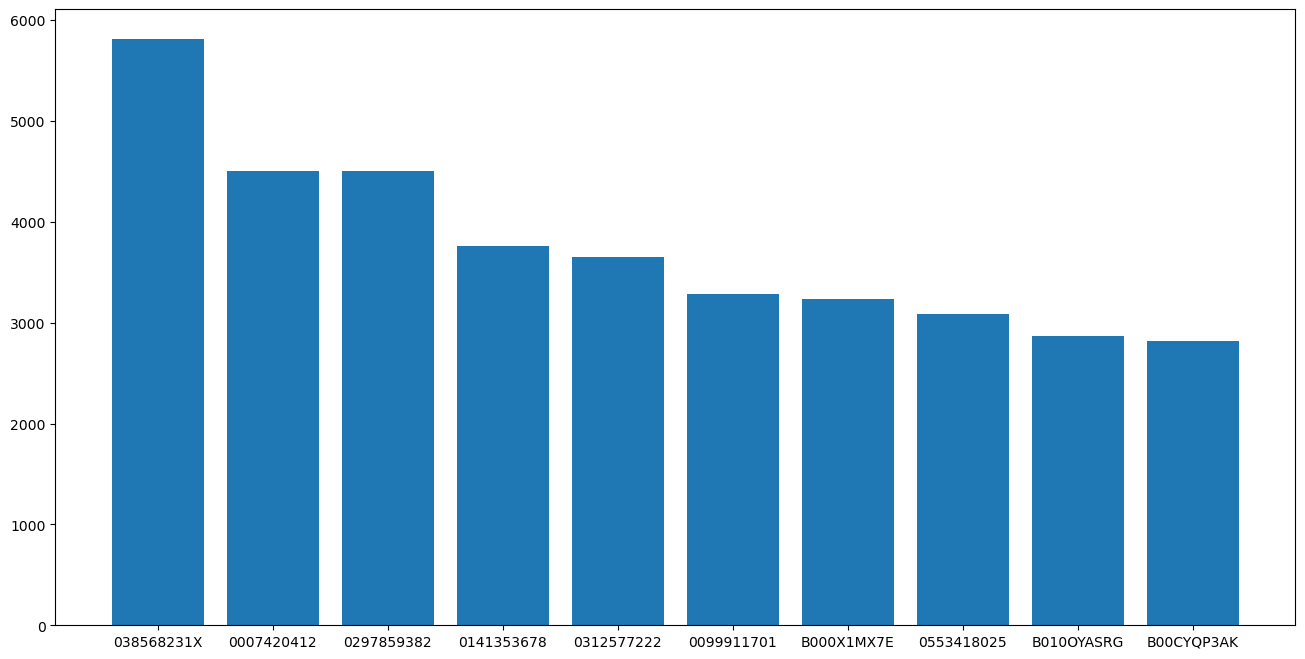

In [12]:
plt.figure(figsize=(16, 8))
plt.bar(top['asin'], top['count'])
plt.show()

Graph above tells us that these Products are most sold during period and it tell us that they most likely to be recommended to user. Even if similarity coefficient between 2 users dont fall inside threshold, we can safely recommend these products.

In [5]:
df = df.dropna(subset=['asin', 'overall','reviewerID','unixReviewTime'])
df['vote'] = df['vote'].fillna(value=0)

In [6]:
results = df.groupby('reviewerID')['vote'].sum()

In [7]:
top_10 = results.nlargest(10).compute()

[########################################] | 100% Completed | 156.11 s


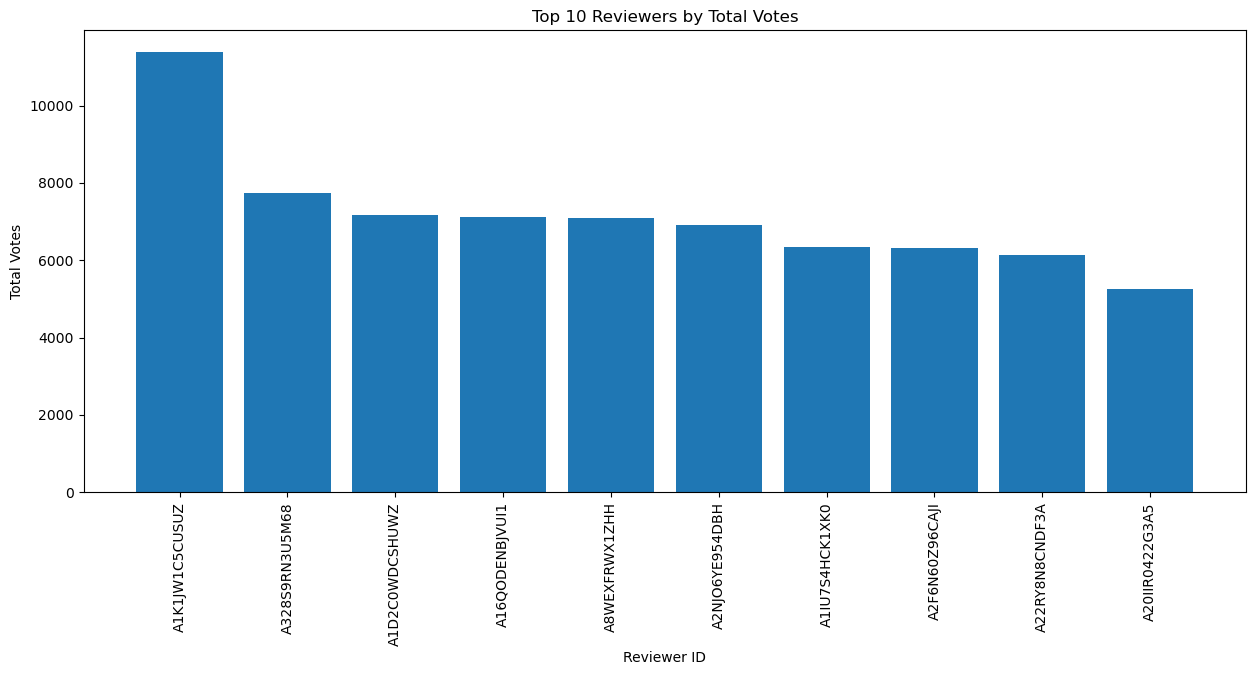

In [14]:
plt.figure(figsize=(15,6))
plt.bar(top_10.index, top_10.values)
plt.title('Top 10 Reviewers by Total Votes')
plt.xlabel('Reviewer ID')
plt.ylabel('Total Votes')
plt.xticks(rotation='vertical')
plt.show()

Above graph tells us that top 10 reviewers with these ID are most trusted because they have most upvotes during the period in which data was collected so we can assume that reviews they provided are accurate and people tend to agree with them.

In [17]:
time = df[['unixReviewTime']].copy()

In [19]:
time = time.sort_values('unixReviewTime', ascending=True)

[########################################] | 100% Completed | 87.74 s


In [45]:
time['unixReviewTime'] = dd.to_datetime(time['unixReviewTime'], unit='s')

In [33]:
time['num'] = time.reset_index().index

In [34]:
starting = time.head(100)

[########################################] | 100% Completed | 45.81 s


In [35]:
ending = time.tail(100)

[########################################] | 100% Completed | 44.66 s


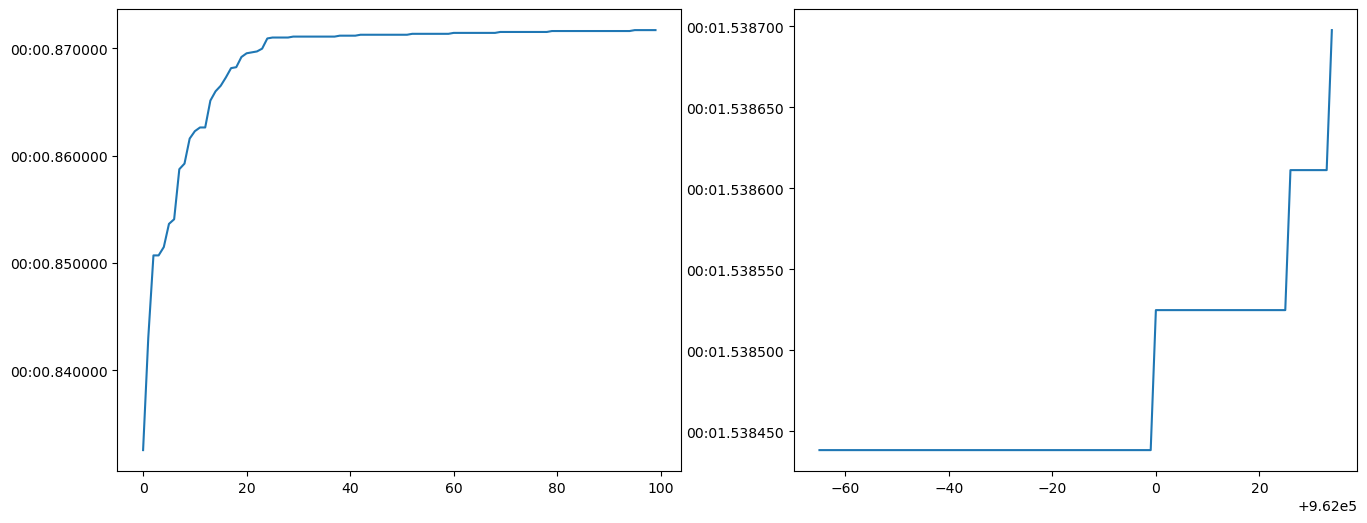

In [50]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(starting['num'],starting['unixReviewTime'])

plt.subplot(1, 2, 2)
plt.plot(ending['num'],ending['unixReviewTime'])

plt.show()

The graph on left tell us number products that are reviewed at start of data collection and right graph tells us number products that are reviewed at ending of data collection. This tells us that people are doing online shopping more then ever and that is probably because increasing accessibilty of internet around the world. These graph might not be accurate as not all people post their reviews but it does give us strong idea that our proposition is true.